In [1]:
import re
import string
import warnings
from pathlib import Path
from time import time

import arviz as az
import common_data_processing as dphelp
import matplotlib.colors as mcolors
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import plotnine as gg
import pymc3 as pm
import pymc3_helpers as pmhelp
import seaborn as sns
from theano import tensor as tt

notebook_tic = time()

warnings.simplefilter(action="ignore", category=UserWarning)

gg.theme_set(gg.theme_minimal())
%config InlineBackend.figure_format = "retina"

RANDOM_SEED = 245
np.random.seed(RANDOM_SEED)

pymc3_cache_dir = Path("pymc3_model_cache")

# Modeling with a hierarchical 2D covariate with additional varying levels

This notebook is to experiment with creating a hierarchical covariate with 2 dimensions: gene $\times$ cell line.
Each value in the matrix will come from a model of two varying covariables, one for the gene and one for the cell line.
The cell line covariate will then come from a distribution of the lineage as another level in the model.

## Data preparation

I will need a fair amount of data to fit a model with so many parameters, but I will still start with a subsample of the full data set.

In [27]:
NUM_GENES = 20
NUM_LINEAGES = 5

data_path = Path("../modeling_data")
starting_dataset_path = data_path / "depmap_modeling_dataframe.csv"
final_dataset_path = (
    data_path / "subsample_covariate-matrix_depmap-modeling-dataframe.csv"
)

if final_dataset_path.exists():
    # Read in data set that has already been created.
    print("Reading in existing file.")
    modeling_data = pd.read_csv(final_dataset_path)
else:
    # Read in full data set and subsample some genes and lineages.
    print(
        f"Subsampling {NUM_GENES} genes and {NUM_LINEAGES} lineages from full dataset."
    )
    full_modeling_data = pd.read_csv(starting_dataset_path, low_memory=False)

    GENES = np.random.choice(full_modeling_data.hugo_symbol.unique(), NUM_GENES)
    LINEAGES = np.random.choice(full_modeling_data.lineage.unique(), NUM_LINEAGES)

    modeling_data = full_modeling_data[full_modeling_data.hugo_symbol.isin(GENES)]
    modeling_data = modeling_data[modeling_data.lineage.isin(LINEAGES)]
    modeling_data = modeling_data.reset_index(drop=True)

    modeling_data.to_csv(final_dataset_path)
    del full_modeling_data

Subsampling 20 genes and 5 lineages from full dataset.


In [55]:
print("Genes:")
print(modeling_data.hugo_symbol.unique().tolist())

print("-" * 60)
print("Lineages:")
print(modeling_data.lineage.unique().tolist())

print("-" * 60)
print(f"number of cell lines: {modeling_data.depmap_id.nunique()}")

Genes:
['AAED1', 'ARG1', 'ARHGAP26', 'C18orf54', 'CT47A7', 'DHDH', 'FAM206A', 'GIPR', 'GTF2E1', 'H3F3A', 'HERC1', 'IL17B', 'LGI3', 'NACC2', 'PLEKHH3', 'PRKAR1A', 'RGPD6', 'STRC', 'YPEL5', 'ZNF175']
------------------------------------------------------------
Lineages:
['blood', 'colorectal', 'liver', 'upper_aerodigestive']
------------------------------------------------------------
number of cell lines: 132


In [29]:
modeling_data = modeling_data.sort_values(
    ["hugo_symbol", "sgrna", "lineage", "depmap_id"]
).reset_index(drop=True)

for col in [
    "sgrna",
    "pdna_batch",
    "depmap_id",
    "lineage",
    "kras_mutation",
    "hugo_symbol",
]:
    modeling_data = dphelp.make_cat(modeling_data, col, ordered=True, sort_cats=True)

In [30]:
modeling_data.shape

(22960, 27)

In [31]:
modeling_data.head(5)

,sgrna,replicate_id,lfc,pdna_batch,passes_qc,depmap_id,primary_or_metastasis,lineage,lineage_subtype,kras_mutation,...,log2_gene_cn_p1,gene_cn,n_muts,any_deleterious,variant_classification,is_deleterious,is_tcga_hotspot,is_cosmic_hotspot,mutated_at_guide_location,rna_expr
0,CACCCGCACGAACACCACCA,hel-311cas9_repa_p4_batch3,0.619938,3,True,ACH-000004,NaN,blood,AML,WT,...,NaN,NaN,0,False,NaN,NaN,NaN,NaN,False,NaN
1,CACCCGCACGAACACCACCA,hel-311cas9_repb_p4_batch3,0.780068,3,True,ACH-000004,NaN,blood,AML,WT,...,NaN,NaN,0,False,NaN,NaN,NaN,NaN,False,NaN
2,CACCCGCACGAACACCACCA,hel9217-311cas9_repa_p6_batch3,0.176848,3,True,ACH-000005,NaN,blood,AML,WT,...,NaN,NaN,0,False,NaN,NaN,NaN,NaN,False,NaN
3,CACCCGCACGAACACCACCA,hel9217-311cas9_repb_p6_batch3,0.295670,3,True,ACH-000005,NaN,blood,AML,WT,...,NaN,NaN,0,False,NaN,NaN,NaN,NaN,False,NaN
4,CACCCGCACGAACACCACCA,mv4;11-311cas9_repa_p6_batch2,0.564909,2,True,ACH-000045,Primary,blood,AML,WT,...,NaN,NaN,0,False,NaN,NaN,NaN,NaN,False,NaN


## Data visualization

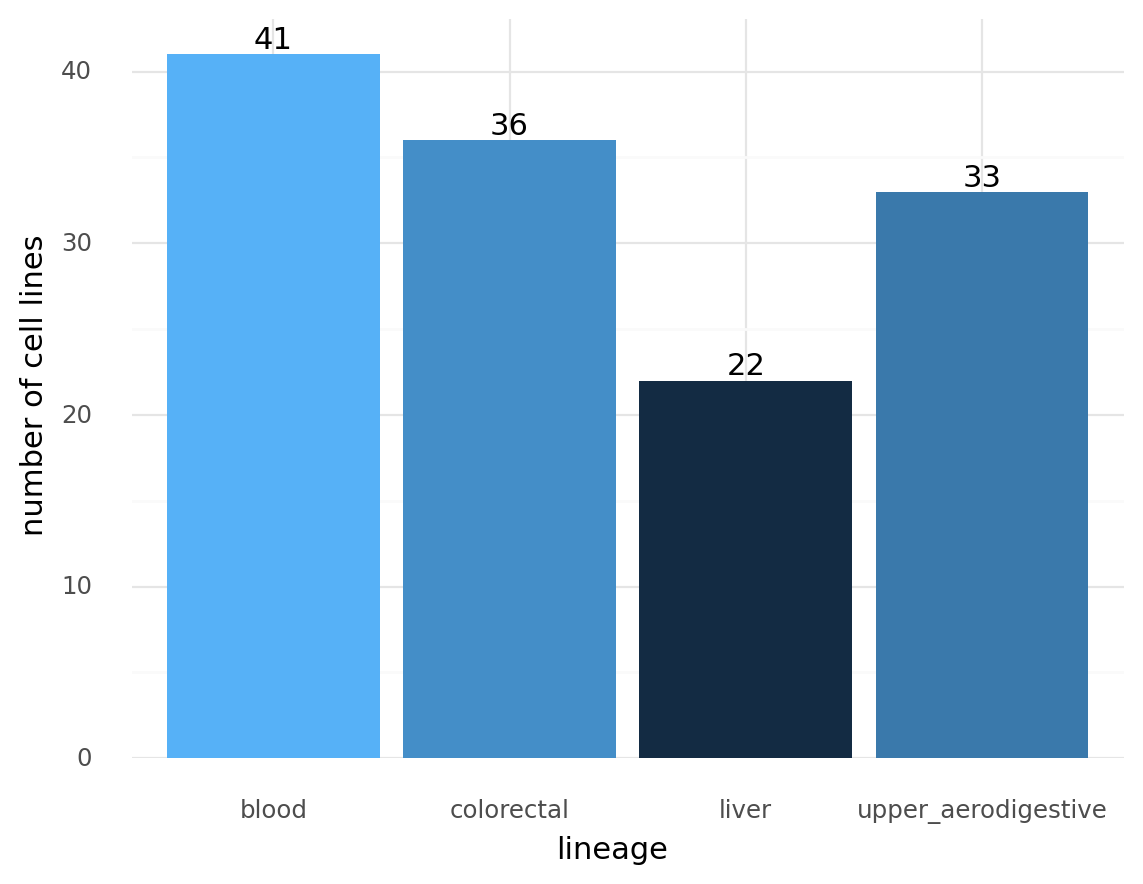

<ggplot: (8770218525257)>

In [32]:
plot_data = (
    modeling_data[["lineage", "depmap_id"]]
    .drop_duplicates()
    .groupby("lineage")
    .count()
    .reset_index()
)

(
    gg.ggplot(plot_data, gg.aes("lineage", "depmap_id"))
    + gg.geom_col(gg.aes(fill="depmap_id"))
    + gg.geom_text(gg.aes(label="depmap_id"), va="bottom")
    + gg.scale_fill_gradient(guide=None)
    + gg.scale_y_continuous(expand=(0, 0, 0.05, 0))
    + gg.labs(x="lineage", y="number of cell lines")
)

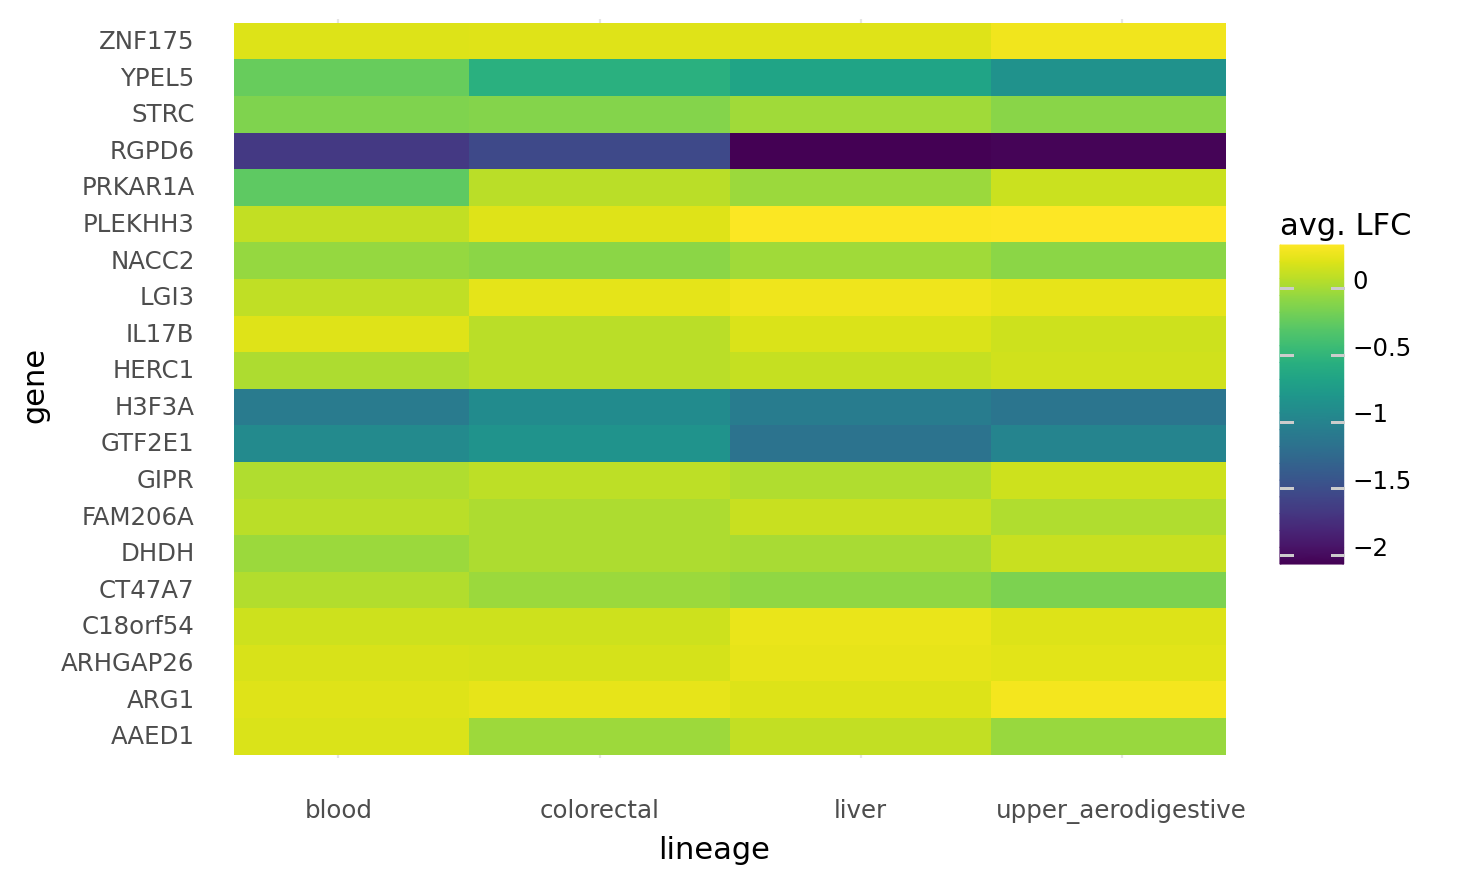

<ggplot: (8770218525326)>

In [33]:
plot_data = (
    modeling_data[["lineage", "hugo_symbol", "lfc"]]
    .groupby(["lineage", "hugo_symbol"])
    .mean()
    .reset_index()
)

(
    gg.ggplot(plot_data, gg.aes(x="lineage", y="hugo_symbol", fill="lfc"))
    + gg.geom_tile()
    + gg.scale_x_discrete(expand=(0.1, 0.1))
    + gg.labs(x="lineage", y="gene", fill="avg. LFC")
)

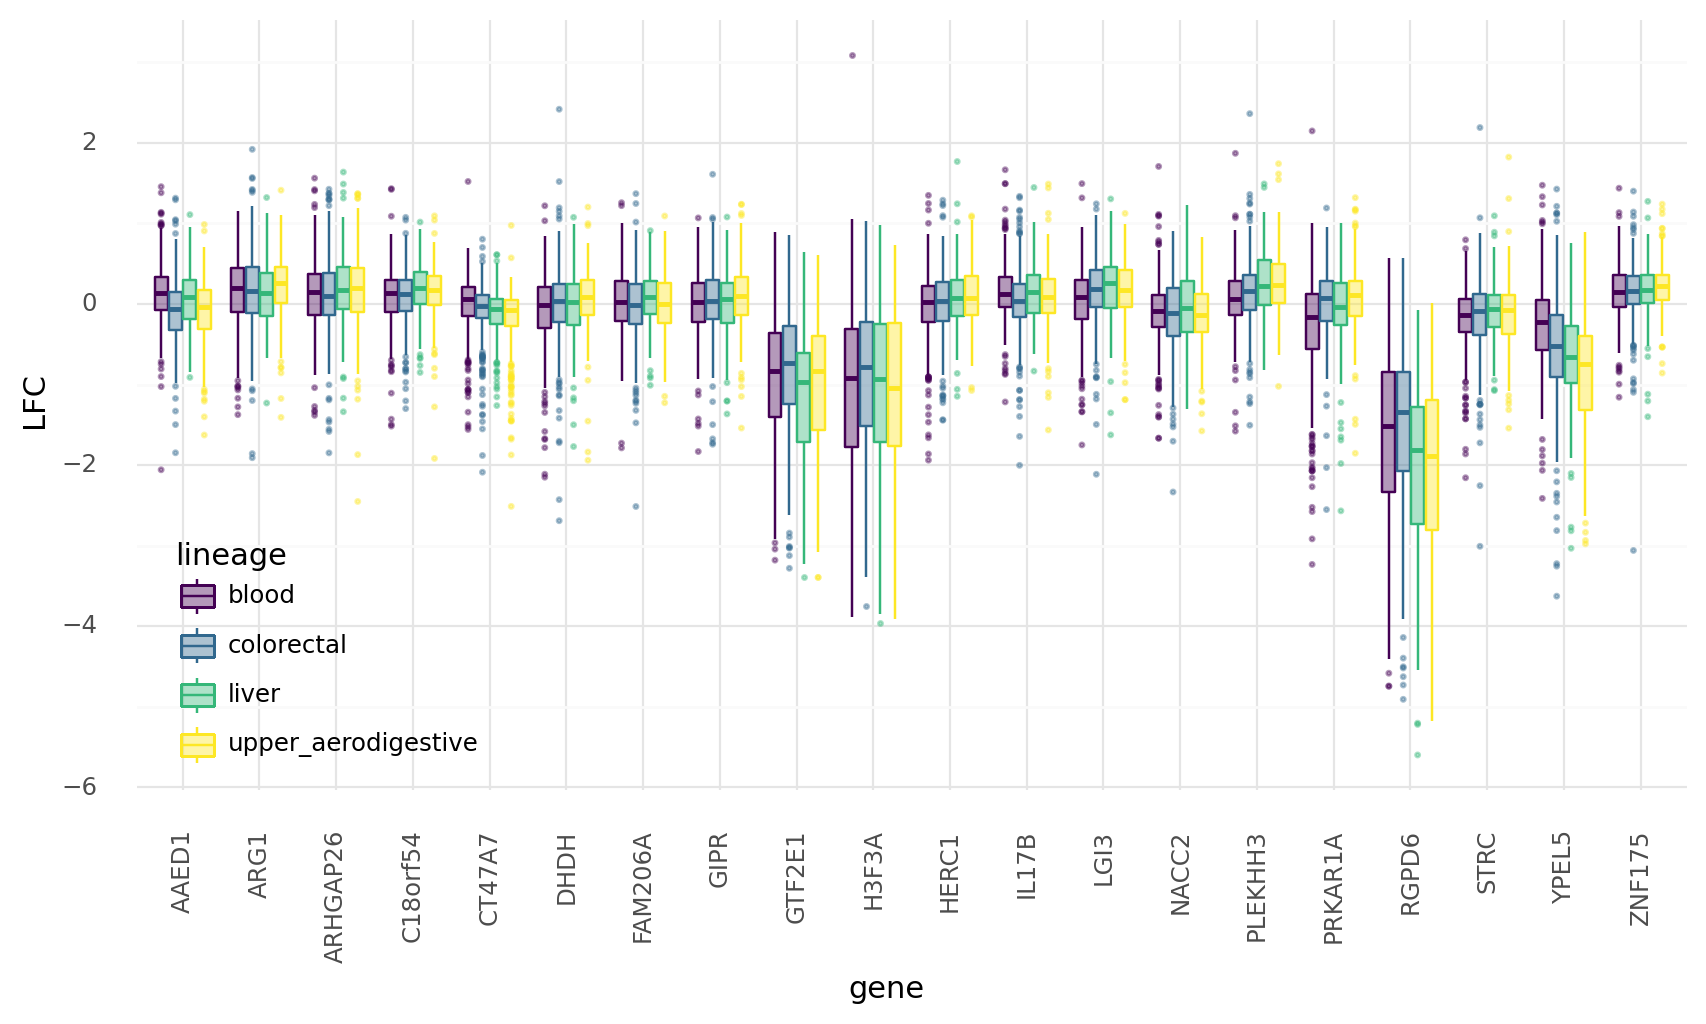

<ggplot: (8770213835424)>

In [34]:
(
    gg.ggplot(modeling_data, gg.aes(x="hugo_symbol", y="lfc"))
    + gg.geom_boxplot(
        gg.aes(color="lineage", fill="lineage"),
        alpha=0.4,
        outlier_alpha=0.4,
        outlier_size=0.4,
    )
    + gg.theme(
        figure_size=(10, 5),
        axis_text_x=gg.element_text(angle=90),
        legend_position=(0.22, 0.25),
    )
    + gg.labs(x="gene", y="LFC", fill="lineage")
)

## Modeling

In [49]:
gene_idx, num_genes = dphelp.get_indices_and_count(modeling_data, "hugo_symbol")

cellline_idx, num_celllines = dphelp.get_indices_and_count(modeling_data, "depmap_id")

cellline_to_lineage_map = (
    modeling_data[["lineage", "depmap_id"]].drop_duplicates().reset_index(drop=True)
)
cellline_to_lineage_idx, num_lineages = dphelp.get_indices_and_count(
    cellline_to_lineage_map, "lineage"
)

In [120]:
with pm.Model() as m1:

    # Indexing arrays
    gene_idx_shared = pm.Data("gene_idx", gene_idx)
    cellline_idx_shared = pm.Data("cellline_idx", cellline_idx)
    cellline_to_lineage_idx_shared = pm.Data(
        "cellline_to_lineage_idx", cellline_to_lineage_idx
    )

    # Data
    lfc_shared = pm.Data("lfc", modeling_data.lfc.to_numpy())

    # Model parameters
    μ_μ_μ_γ = pm.Normal("μ_μ_μ_γ", 3)
    σ_μ_μ_γ = pm.HalfNormal("σ_μ_μ_γ", 3)

    μ_μ_γ = pm.Normal("μ_μ_γ", μ_μ_μ_γ, σ_μ_μ_γ, shape=(num_genes, 1))
    σ_μ_γ = pm.HalfNormal("σ_μ_γ", 3)

    μ_γ = pm.Normal("μ_γ", μ_μ_γ, σ_μ_γ, shape=(num_genes, num_lineages))
    σ_γ = pm.HalfNormal("σ_γ", 3)

    γ = pm.Normal(
        "γ",
        μ_γ[:, cellline_to_lineage_idx_shared],
        σ_γ,
        shape=(num_genes, num_celllines),
    )

    μ = pm.Deterministic("μ", γ[gene_idx_shared, cellline_idx_shared])
    σ = pm.HalfNormal("σ", 3)

    # Likelihood
    y = pm.Normal("y", μ, σ, observed=lfc_shared)

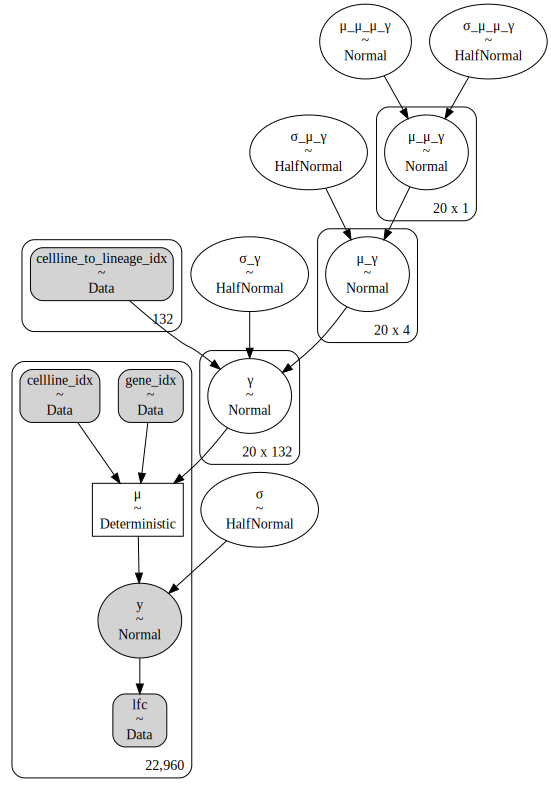

In [121]:
pm.model_to_graphviz(m1)

In [119]:
m1_cache_dir = pymc3_cache_dir / "gene-lineage-model_m1"

m1_sampling_results = pmhelp.pymc3_sampling_procedure(
    model=m1,
    num_mcmc=3000,
    tune=4000,
    chains=4,
    cores=4,
    random_seed=RANDOM_SEED,
    cache_dir=m1_cache_dir,
    force=False,
    sample_kwargs={"init": "advi+adapt_diag", "n_init": 500000},
)

m1_az = pmhelp.samples_to_arviz(model=m1, res=m1_sampling_results)

Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...


Interrupted at 2,737 [0%]: Average Loss = 80,093


KeyboardInterrupt: 

In [72]:
az.summary(m1_az, var_names=["σ_μ_μ_γ", "μ_μ_μ_γ"], hdi_prob=0.89)

,mean,sd,hdi_5.5%,hdi_94.5%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
σ_μ_μ_γ,0.540,0.097,0.394,0.681,0.001,0.001,10071.0,8590.0,12290.0,6218.0,1.0
μ_μ_μ_γ,-0.135,0.125,-0.328,0.067,0.001,0.001,8478.0,7397.0,8896.0,5171.0,1.0


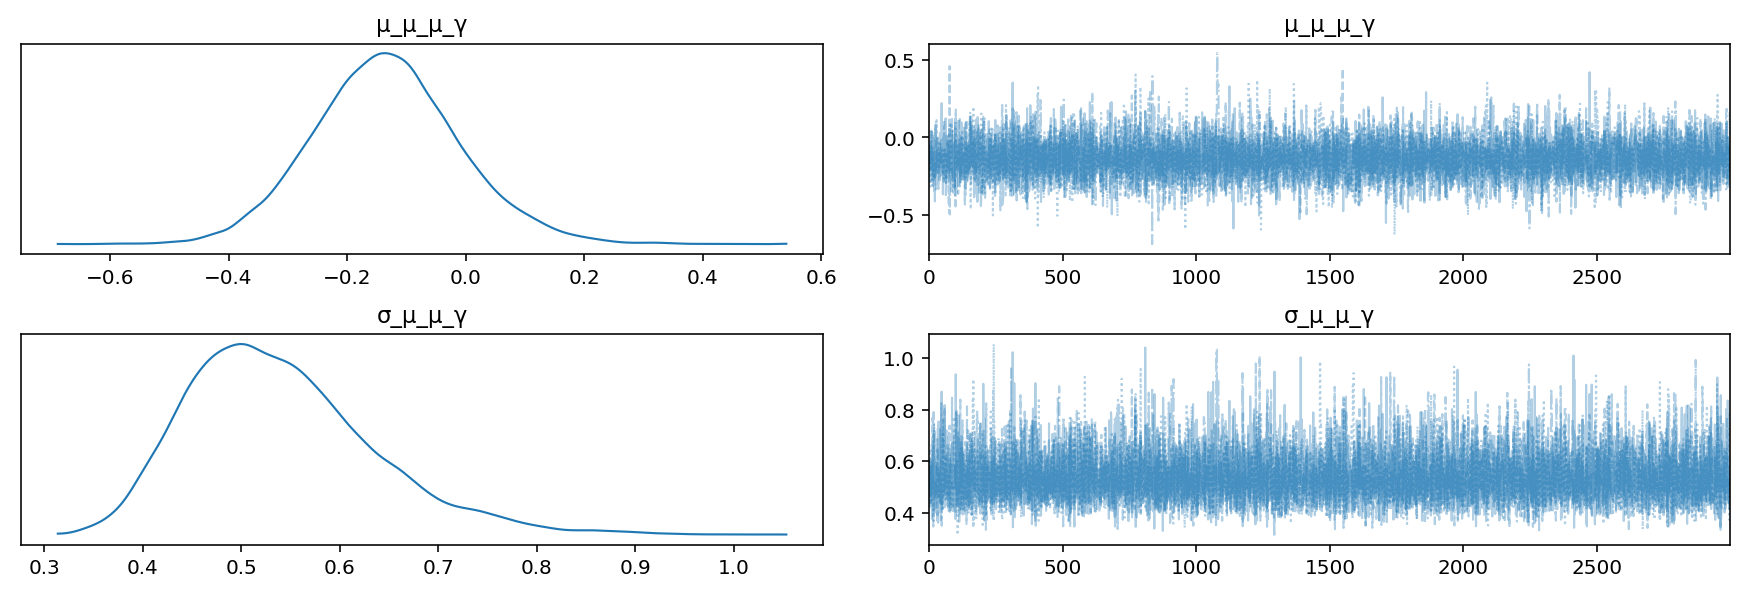

In [73]:
az.plot_trace(m1_az, var_names=["μ_μ_μ_γ", "σ_μ_μ_γ"], combined=True)
plt.show()

In [75]:
gamma_post_summary = az.summary(m1_az, var_names="γ", hdi_prob=0.89, kind="stats")

In [76]:
gamma_post_summary.head()

,mean,sd,hdi_5.5%,hdi_94.5%
"γ[0,0]",0.191,0.144,-0.038,0.422
"γ[0,1]",0.072,0.145,-0.156,0.310
"γ[0,2]",-0.067,0.142,-0.298,0.156
"γ[0,3]",-0.252,0.122,-0.436,-0.045
"γ[0,4]",0.128,0.146,-0.103,0.358


In [102]:
def extract_matrix_variable_indices(
    d: pd.DataFrame,
    col: str,
    idx1: np.ndarray,
    idx2: np.ndarray,
    idx1name: str,
    idx2name: str,
) -> pd.DataFrame:
    indices_list = [
        [int(x) for x in re.findall("[0-9]+", s)] for s in d[[col]].to_numpy().flatten()
    ]
    indices_array = np.asarray(indices_list)
    d[idx1name] = idx1[indices_array[:, 0]]
    d[idx2name] = idx2[indices_array[:, 1]]
    return d


gamma_post_summary = (
    gamma_post_summary.reset_index()
    .rename(columns={"index": "variable"})
    .pipe(
        extract_matrix_variable_indices,
        col="variable",
        idx1=modeling_data.hugo_symbol.unique(),
        idx2=modeling_data.depmap_id.unique(),
        idx1name="hugo_symbol",
        idx2name="depmap_id",
    )
)

In [107]:
gamma_post_summary = gamma_post_summary.merge(
    cellline_to_lineage_map, on="depmap_id", left_index=False, right_index=False
)

In [108]:
gamma_post_summary.head()

,variable,mean,sd,hdi_5.5%,hdi_94.5%,hugo_symbol,depmap_id,lineage
0,"γ[0,0]",0.191,0.144,-0.038,0.422,AAED1,ACH-000004,blood
1,"γ[1,0]",0.247,0.143,0.020,0.477,ARG1,ACH-000004,blood
2,"γ[2,0]",0.121,0.142,-0.110,0.340,ARHGAP26,ACH-000004,blood
3,"γ[3,0]",0.084,0.147,-0.165,0.306,C18orf54,ACH-000004,blood
4,"γ[4,0]",0.001,0.133,-0.210,0.213,CT47A7,ACH-000004,blood


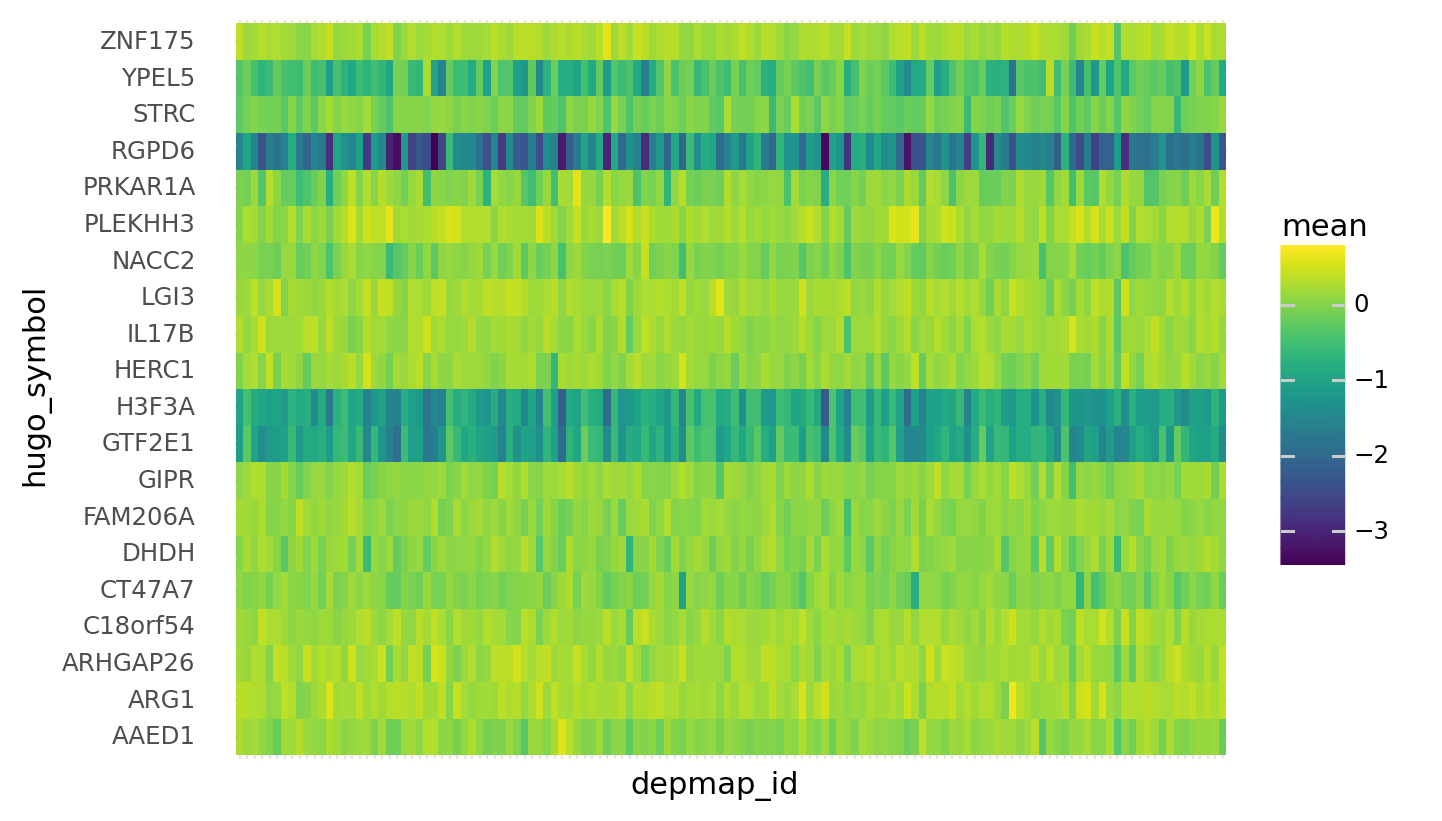

<ggplot: (8770121041577)>

In [111]:
(
    gg.ggplot(gamma_post_summary, gg.aes(x="depmap_id", y="hugo_symbol"))
    + gg.geom_tile(gg.aes(fill="mean"))
    + gg.theme(axis_text_x=gg.element_blank())
)

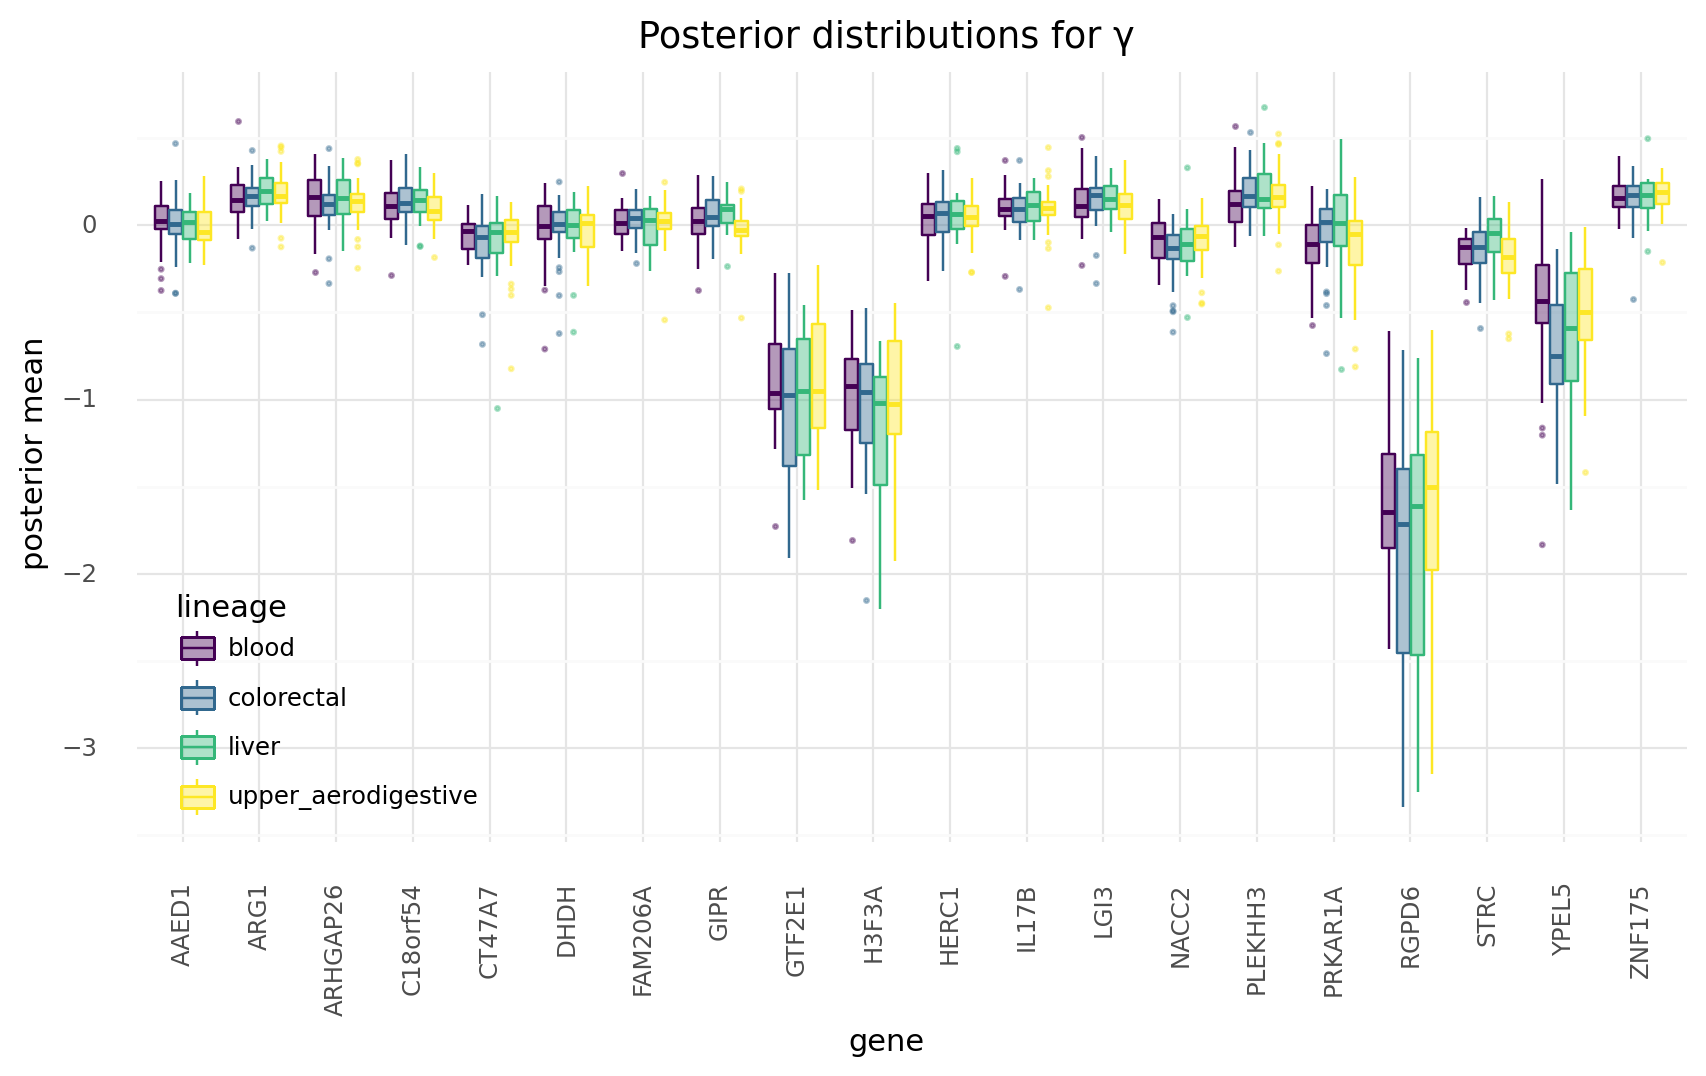

<ggplot: (8770120674392)>

In [113]:
(
    gg.ggplot(gamma_post_summary, gg.aes(x="hugo_symbol", y="mean"))
    + gg.geom_boxplot(
        gg.aes(color="lineage", fill="lineage"),
        alpha=0.4,
        outlier_alpha=0.4,
        outlier_size=0.4,
    )
    + gg.theme(
        figure_size=(10, 5),
        axis_text_x=gg.element_text(angle=90),
        legend_position=(0.22, 0.25),
    )
    + gg.labs(
        x="gene",
        y="posterior mean",
        fill="lineage",
        title="Posterior distributions for γ",
    )
)

## Modeling

This is a model with the following features:

- the primary level is $\mu = \alpha_s + \beta_c + \gamma_{gc}$
- $\alpha_s$ is a varying intercept by sgRNA which comes from a distribution for the target gene: $\mathcal{N}(\mu_\alpha, \sigma_\alpha)$
- $\beta_c$ is a varying intercept by cell line which comes from a distribution for the lineage: $\mathcal{N}(\mu_\beta, \sigma_\beta)$
- $\gamma_{gc}$ is a  2-dimensional varying intercept - one for the gene and one for the cell line
    - the mean of the distribution for $\gamma_{gc}$ is $\mu_\gamma = \eta_g + \theta_c$ so it is linked the gene and cell line
    - the standard deviation for this distribution $\sigma_\gamma$ varying by gene as the lineage specificity can vary to differing degrees per gene
    - $\eta_g$ comes from a distribution of genes and $\theta_c$ comes from a distribution of cell lines which has an additional level for the lineages of the cell lines

---

$
lfc \sim \mathcal{N}(\mu, \sigma) \\
\mu = \alpha_s + \beta_c + \gamma_{gc} \\
\
\quad \alpha_s \sim \mathcal{N}(\mu_{\alpha}, \sigma_{\alpha}) \\
\qquad \mu_{\alpha} \sim \mathcal{N}(\mu_{\mu_{\alpha}}, \sigma_{\mu_{\alpha}}) \\
\qquad \quad \mu_{\mu_{\alpha}} \sim \mathcal{N}(0, 3) \\
\qquad \quad \sigma_{\mu_{\alpha}} \sim \text{HalfNormal}(3) \\
\qquad \sigma_{\alpha} \sim \text{HalfNormal}(\sigma_{\sigma_{\alpha}}) \\
\qquad \quad \sigma_{\sigma_{\alpha}} \sim \text{HalfNormal}(3) \\
\
\quad \beta_c \sim \mathcal{N}(\mu_{\beta}, \sigma_{\beta}) \\
\qquad \mu_{\beta} \sim \mathcal{N}(\mu_{\mu_{\beta}}, \sigma_{\mu_{\beta}}) \\
\qquad \quad \mu_{\mu_{\beta}} \sim \mathcal{N}(0, 3) \\
\qquad \quad \sigma_{\mu_{\beta}} \sim \text{HalfNormal}(3) \\
\qquad \sigma_{\beta} \sim \text{HalfNormal}(\sigma_{\sigma_{\beta}}) \\
\qquad \quad \sigma_{\sigma_{\beta}} \sim \text{HalfNormal}(3) \\
\
\quad \gamma_{gc} \sim \mathcal{N}(\mu_{\gamma}, \sigma_{\gamma}) \\
\qquad \mu_{\gamma} = \eta_g + \theta_c \\
\qquad \quad \eta_g \sim \mathcal{N}(\mu_{\eta}, \sigma_{\eta}) \\
\qquad \qquad \mu_{\eta} \sim \mathcal{N}(0, 3) \\
\qquad \qquad \sigma_{\eta} \sim \text{HalfNormal}(0, 3) \\
\
\qquad \quad \theta_c \sim \mathcal{N}(\mu_{\theta}, \sigma_{\theta}) \\
\qquad \qquad \mu_{\theta} \sim \mathcal{N}(\mu_{\mu_\theta}, \sigma_{\mu_\theta}) \\
\qquad \qquad \quad \mu_{\mu_\theta} \sim \mathcal{N}(0, 3) \\
\qquad \qquad \quad \sigma_{\mu_\theta} \sim \text{HalfNormal}(3) \\
\qquad \qquad \sigma_{\theta} \sim \text{HalfNormal}(\sigma_{\sigma_\theta}) \\
\qquad \qquad \quad \sigma_{\sigma_\theta} \sim \text{HalfNormal}(3) \\
\
\qquad \sigma_{\gamma} \sim \text{HalfNormal}(\sigma_{\sigma_{\gamma}}) \\
\qquad \quad \sigma_{\sigma_{\gamma}} \sim \text{HalfNormal}(1) \\
\
\sigma \sim \text{HalfNormal}(3)
$

In [44]:
# Index sgRNAs and genes for full data.
sgrna_idx, num_sgrnas = dphelp.get_indices_and_count(modeling_data, "sgrna")
gene_idx, num_genes = dphelp.get_indices_and_count(modeling_data, "hugo_symbol")

# Index genes for sgRNAs.
sgrna_gene_mapping_df = (
    modeling_data[["hugo_symbol", "sgrna"]].drop_duplicates().reset_index(drop=True)
)
sgrna_gene_idx = dphelp.get_indices(sgrna_gene_mapping_df, "hugo_symbol")

# Index of genes for γ.
γ_gene_idx = dphelp.get_indices(
    modeling_data[["hugo_symbol"]].drop_duplicates().reset_index(drop=True),
    "hugo_symbol",
)


# Index cell lines for full data set.
cellline_idx, num_celllines = dphelp.get_indices_and_count(modeling_data, "depmap_id")
_, num_lineages = dphelp.get_indices_and_count(modeling_data, "lineage")

# Index lineages for cell lines.
cellline_lineage_mapping_df = (
    modeling_data[["lineage", "depmap_id"]].drop_duplicates().reset_index(drop=True)
)
cellline_lineage_idx = dphelp.get_indices(cellline_lineage_mapping_df, "lineage")

In [42]:
with pm.Model() as m8:

    # Indexing arrays
    sgrna_idx_shared = pm.Data("sgrna_idx", sgrna_idx)
    gene_idx_shared = pm.Data("gene_idx", gene_idx)
    sgrna_gene_idx_shared = pm.Data("sgrna_gene_idx", sgrna_gene_idx)
    cellline_idx_shared = pm.Data("cellline_idx", cellline_idx)
    cellline_lineage_idx_shared = pm.Data("cellline_lineage_idx", cellline_lineage_idx)

    # Data
    lfc_shared = pm.Data("lfc", modeling_data.lfc.to_numpy())

    μ_μ_α = pm.Normal("μ_μ_α", 0, 3)
    σ_μ_α = pm.HalfNormal("σ_μ_α", 3)
    σ_σ_α = pm.HalfNormal("σ_σ_α", 3)
    μ_α = pm.Normal("μ_α", μ_μ_α, σ_μ_α, shape=num_genes)
    σ_α = pm.HalfNormal("σ_α", σ_σ_α, shape=num_genes)

    μ_μ_β = pm.Normal("μ_μ_β", 0, 3)
    σ_μ_β = pm.HalfNormal("σ_μ_β", 3)
    σ_σ_β = pm.HalfNormal("σ_σ_β", 3)
    μ_β = pm.Normal("μ_β", μ_μ_β, σ_μ_β, shape=num_lineages)
    σ_β = pm.HalfNormal("σ_β", σ_σ_β, shape=num_lineages)

    σ_σ_γ = pm.HalfNormal("σ_σ_γ", 1)
    #     μ_γ = pm.Deterministic("μ_γ", η[gene_idx_shared] + θ[cellline_idx_shared])
    μ_γ = pm.Normal("μ_γ", 0, 5)
    σ_γ = pm.HalfNormal("σ_γ", σ_σ_γ, shape=(num_genes))

    α = pm.Normal(
        "α", μ_α[sgrna_gene_idx_shared], σ_α[sgrna_gene_idx_shared], shape=num_sgrnas
    )
    β = pm.Normal(
        "β",
        μ_β[cellline_lineage_idx_shared],
        σ_β[cellline_lineage_idx_shared],
        shape=num_celllines,
    )
    γ = pm.Normal("γ", μ_γ, σ_γ, shape=(num_genes, num_celllines))

    μ = pm.Deterministic(
        "μ",
        α[sgrna_idx_shared]
        + β[cellline_idx_shared]
        + γ[gene_idx_shared, cellline_idx_shared],
    )
    σ = pm.HalfNormal("σ", 3)

    y = pm.Normal("y", μ, σ, observed=lfc_shared)

In [ ]:
pm.model_to_graphviz(m8)

---

In [46]:
notebook_toc = time()
print(f"execution time: {(notebook_toc - notebook_tic) / 60:.2f} minutes")

execution time: 28.69 minutes


In [47]:
%load_ext watermark
%watermark -d -u -v -iv -b -h -m

Last updated: 2021-01-27

Python implementation: CPython
Python version       : 3.9.1
IPython version      : 7.19.0

Compiler    : GCC 9.3.0
OS          : Linux
Release     : 3.10.0-1062.el7.x86_64
Machine     : x86_64
Processor   : x86_64
CPU cores   : 28
Architecture: 64bit

Hostname: compute-e-16-230.o2.rc.hms.harvard.edu

Git branch: data-subset-model

seaborn   : 0.11.1
plotnine  : 0.7.1
matplotlib: 3.3.3
re        : 2.2.1
numpy     : 1.19.5
pymc3     : 3.9.3
arviz     : 0.11.0
theano    : 1.0.5
pandas    : 1.2.0

